In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
import numpy as np
import scanpy.api as sc
import scipy as sci
import re
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.verbosity = 3 # amount of output
dir_in = 'your_project_raw_data_input_directory' 
dir_root = 'your_project_root_directory'
sc.settings.figdir = dir_root+'scanpy'
sc.settings.writedir = dir_root+'scanpy'
sc.settings.set_dpi(60) # low pixel number yields small inline figures
sc.logging.print_version_and_date()

/Users/david/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Running Scanpy 0.4.3+21.g0caaa9d on 2018-02-23 09:22.


In [2]:
# read raw data matrix
filename_data = dir_in+'GSE87375_Single_Cell_RNA-seq_Gene_Read_Count.txt'
data = pandas.read_table(filename_data)

In [3]:
# extract counts from data matrix
cnts = data.iloc[:,3:].as_matrix()

In [4]:
# assemble AnnData object
adata = sc.AnnData(cnts.transpose())
adata.obs_names = data.columns.values[3:]
adata.obs['sample'] = [s.split("_")[0] for s in adata.obs_names]
adata.obs['type'] = [s[0] for s in adata.obs_names]
adata.var_names = data.iloc[:,1]
adata_b = adata[adata.obs_names[adata.obs['type']=="b"].tolist(),].copy()

{} names are not unique. To make them unique, call `.{}_names_make_unique()`.

{} names are not unique. To make them unique, call `.{}_names_make_unique()`.



In [5]:
# find root cell via diffusion map
sc.tl.diffmap(adata_b, n_neighbors=30, knn=False, n_comps= 10,
              n_pcs=50, n_jobs=1, flavor='haghverdi16')

computing Diffusion Maps
    compute 'X_pca' with n_pcs = 50 for building graph
    computing data graph with n_neighbors = 30 
    computing spectral decomposition ("diffmap") with 10 components
    eigenvalues of transition matrix
    [1.0000002  0.97798693 0.9316826  0.87818205 0.8343163  0.8142164
     0.77023137 0.73905385 0.71210337 0.6946958 ]
    finished (0:00:00.045) --> added
    'X_diffmap', tSNE coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)


... storing sample as categorical type
    access categories as adata.obs['sample'].cat.categories
... storing type as categorical type
    access categories as adata.obs['type'].cat.categories


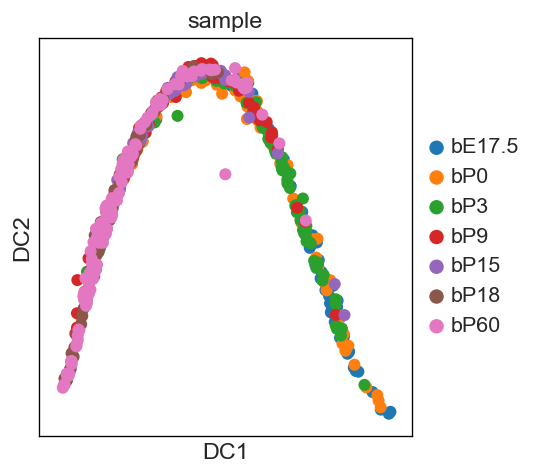

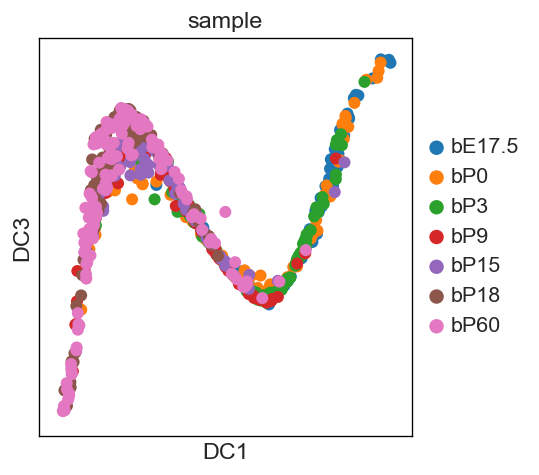

In [6]:
sc.pl.diffmap(adata_b, components='1,2', color='sample')
sc.pl.diffmap(adata_b, components='1,3', color='sample')

In [7]:
idxRoot = np.argmax(adata_b.obsm['X_diffmap'][:,0])
print(idxRoot) # 559
adata_b.uns['iroot'] = idxRoot

559


In [8]:
# compute cell state ordering: diffusion pseudotime
sc.tl.dpt(adata_b, n_neighbors=30, knn=False, recompute_graph=False, recompute_pca=False)

--> set parameter `n_branchings` > 0 to detect branchings
performing Diffusion Pseudotime analysis
    using 'X_pca' with n_pcs = 50 for building graph
    computing data graph with n_neighbors = 30 
    computing spectral decomposition ("diffmap") with 10 components
    eigenvalues of transition matrix
    [1.0000002  0.97798693 0.9316826  0.87818205 0.8343163  0.8142164
     0.77023137 0.73905385 0.71210337 0.6946958 ]
    detect 0 branchings
    do not consider groups with less than 5 points for splitting
    finished (0:00:00.046) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs)


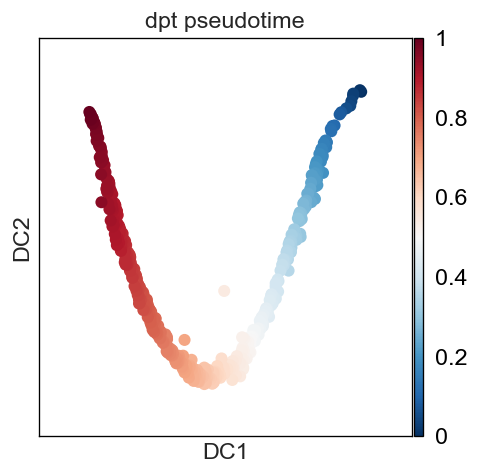

In [9]:
sc.pl.dpt_scatter(adata_b, components='1,2')
plt.scatter(adata_b.smp['dpt_pseudotime'], adata_b.obsm['X_pca'][:,1])

In [10]:
# save results
pandas.DataFrame(adata_b.smp).to_csv(
    path_or_buf =dir_root+'dimreds/dpt_qiu17_beta.csv')
pandas.DataFrame(adata_b.obsm['X_diffmap']).to_csv(
    path_or_buf =dir_root+'dimreds/dpt_qiu17_beta_diffmap.csv')
pandas.DataFrame(adata_b.obsm['X_pca']).to_csv(
    path_or_buf =dir_root+'dimreds/dpt_qiu17_beta_pca.csv')
pandas.DataFrame(adata_b.X).to_csv(
    path_or_buf =dir_root+'dimreds/dpt_qiu17_beta_counts.csv')
pandas.DataFrame(adata_b.var_names).to_csv(
    path_or_buf =dir_root+'dimreds/dpt_qiu17_beta_genenames.csv')
pandas.DataFrame(adata_b.X.transpose()).to_csv(
    path_or_buf =dir_in+'dpt_qiu17_beta_counts.csv')
pandas.DataFrame(adata_b.var_names).to_csv(
    path_or_buf =dir_in+'dpt_qiu17_beta_genes.csv')